<a href="https://colab.research.google.com/github/aalr007/MAAM/blob/main/A4_DL_TC5033_text_generator_integradov2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center> ***Métodos Avanzados de Aprendizaje Máquina*** </center>
## <center> ***Equipo 38*** </center>
## <center> ***Activity 4a*** </center>
### Profesor: Dr José Antonio Cantoral Cevallos
### Alumnos:
* Luis Alfredo Negron Naldos A01793865
* Javier Muñoz Barrios A01794423
* Aurelio Antonio Lozano Rábago A01081266

#### <p style='text-align: right;'> Noviembre del 2023 </p>

## TC 5033
### Text Generation

<br>

#### Activity 4: Building a Simple LSTM Text Generator using WikiText-2
<br>

- Objective:
    - Gain a fundamental understanding of Long Short-Term Memory (LSTM) networks.
    - Develop hands-on experience with sequence data processing and text generation in PyTorch. Given the simplicity of the model, amount of data, and computer resources, the text you generate will not replace ChatGPT, and results must likely will not make a lot of sense. Its only purpose is academic and to understand the text generation using RNNs.
    - Enhance code comprehension and documentation skills by commenting on provided starter code.
    
<br>

- Instructions:
    - Code Understanding: Begin by thoroughly reading and understanding the code. Comment each section/block of the provided code to demonstrate your understanding. For this, you are encouraged to add cells with experiments to improve your understanding

    - Model Overview: The starter code includes an LSTM model setup for sequence data processing. Familiarize yourself with the model architecture and its components. Once you are familiar with the provided model, feel free to change the model to experiment.

    - Training Function: Implement a function to train the LSTM model on the WikiText-2 dataset. This function should feed the training data into the model and perform backpropagation.

    - Text Generation Function: Create a function that accepts starting text (seed text) and a specified total number of words to generate. The function should use the trained model to generate a continuation of the input text.

    - Code Commenting: Ensure that all the provided starter code is well-commented. Explain the purpose and functionality of each section, indicating your understanding.

    - Submission: Submit your Jupyter Notebook with all sections completed and commented. Include a markdown cell with the full names of all contributing team members at the beginning of the notebook.
    
<br>

- Evaluation Criteria:
    - Code Commenting (60%): The clarity, accuracy, and thoroughness of comments explaining the provided code. You are suggested to use markdown cells for your explanations.

    - Training Function Implementation (20%): The correct implementation of the training function, which should effectively train the model.

    - Text Generation Functionality (10%): A working function is provided in comments. You are free to use it as long as you make sure to uderstand it, you may as well improve it as you see fit. The minimum expected is to provide comments for the given function.

    - Conclusions (10%): Provide some final remarks specifying the differences you notice between this model and the one used  for classification tasks. Also comment on changes you made to the model, hyperparameters, and any other information you consider relevant. Also, please provide 3 examples of generated texts.



In [ ]:
import numpy as np
#PyTorch libraries
import torch
import torchtext
from torchtext.datasets import WikiText2
# Dataloader library
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.dataset import random_split
# Libraries to prepare the data
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.functional import to_map_style_dataset
# neural layers
from torch import nn
from torch.nn import functional as F
import torch.optim as optim
from tqdm import tqdm

import random

Check if GPU is available to use it

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


Read the data set and split into train, validation and test

In [ ]:
train_dataset, val_dataset, test_dataset = WikiText2()

Function definition to Tokenize the words using basic english dictionary

In [ ]:
tokeniser = get_tokenizer('basic_english')
def yield_tokens(data):
    for text in data:
        yield tokeniser(text)

Now build the vocabulary available on the dataset using the tokens

In [ ]:
# Build the vocabulary
vocab = build_vocab_from_iterator(yield_tokens(train_dataset), specials=["<unk>", "<pad>", "<bos>", "<eos>"]) #from torchtext.vocab
#set unknown token at position 0
vocab.set_default_index(vocab["<unk>"])

Data_process tokenizes the each element in the dataset and creates the tensors, removes the empty tensors and concatenates the tensors in data

In [ ]:
seq_length = 50
def data_process(raw_text_iter, seq_length = 50):
    data = [torch.tensor(vocab(tokeniser(item)), dtype=torch.long) for item in raw_text_iter] #call tokenization
    data = torch.cat(tuple(filter(lambda t: t.numel() > 0, data))) #remove empty tensors
#     target_data = torch.cat(d)
    return (data[:-(data.size(0)%seq_length)].view(-1, seq_length), #concatenate the tensors
            data[1:-(data.size(0)%seq_length-1)].view(-1, seq_length))

# # Create tensors for the training set
x_train, y_train = data_process(train_dataset, seq_length)
x_val, y_val = data_process(val_dataset, seq_length)
x_test, y_test = data_process(test_dataset, seq_length)

create the data package for train (include the x part and y part of each dataset into one)

In [ ]:
train_dataset = TensorDataset(x_train, y_train) #train data and label
val_dataset = TensorDataset(x_val, y_val) #validation data and label
test_dataset = TensorDataset(x_test, y_test) #test data and labels

Create the dataloaders using a batch size of 64, shuffling the data each epoch and disregard last batch if size is shorter than 64 to ensure bacth consistency

In [ ]:
batch_size = 64  # choose a batch size that fits your computation resources
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

Create a class for LSTM

In [ ]:
# Define the LSTM model
# Feel free to experiment
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers): #initialize the model structure
        super(LSTMModel, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embed_size)  #embedding layer to convert the word representations into dense vectors
        self.hidden_size = hidden_size #number of units on the hidden layers
        self.num_layers = num_layers #number of layers in the LSTM
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True) #LSTM layer with num_layers layers and hidden_size units in each layer
        self.fc = nn.Linear(hidden_size, vocab_size) #fully connected layer

    def forward(self, text, hidden): #forward propagation
        embeddings = self.embeddings(text) #embedding layer
        output, hidden = self.lstm(embeddings, hidden) #pass thru LSTM
        decoded = self.fc(output) #lineal layer
        return decoded, hidden

    def init_hidden(self, batch_size): #initialize the hidden layer of the LSTM

        return (torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device),
                torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device))



vocab_size = len(vocab) # vocabulary size
emb_size = 100 # embedding size
neurons = 128 # the dimension of the feedforward network model, i.e. # of neurons
num_layers = 1 # the number of nn.LSTM layers
model = LSTMModel(vocab_size, emb_size, neurons, num_layers)


- Training Function: Implement a function to train the LSTM model on the WikiText-2 dataset. This function should feed the training data into the model and perform backpropagation.

In [ ]:
def train(model, epochs, optimiser):
    '''
    The following are possible instructions you may want to conside for this function.
    This is only a guide and you may change add or remove whatever you consider appropriate
    as long as you train your model correctly.
        - loop through specified epochs
        - loop through dataloader
        - don't forget to zero grad!
        - place data (both input and target) in device
        - init hidden states e.g. hidden = model.init_hidden(batch_size)
        - run the model
        - compute the cost or loss
        - backpropagation
        - Update paratemers
        - Include print all the information you consider helpful

    '''


    model = model.to(device=device)
    model.train()


    for epoch in range(epochs): #- loop through specified epochs
        total_loss = 0
        for i, (data, targets) in enumerate(train_loader): #- loop through dataloader
            optimiser.zero_grad()  # Zero gradients

            # Move data to the device
            data, targets = data.to(device), targets.to(device) #- place data (both input and target) in device

            # Initialize hidden states
            hidden = model.init_hidden(data.size(0)) #init hidden states e.g. hidden = model.init_hidden(batch_size)

            # Forward pass
            outputs, hidden = model(data, hidden)

            # Compute the loss
            loss = loss_function(outputs.view(-1, vocab_size), targets.view(-1)) # - compute the cost or loss


            # Backward pass
            loss.backward() #- backpropagation

            # Update parameters
            optimiser.step() #- Update paratemers

            # Accumulate the total loss
            total_loss += loss.item()

            if i % 100 == 0:  # Print every 100 batches
                print(f'Epoch {epoch + 1}/{epochs}, Batch {i}/{len(train_loader)}, Loss: {loss.item():.4f}')

        # Print the average loss for the epoch
        average_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch + 1}/{epochs}, Average Loss: {average_loss:.4f}')

    print('Training complete.')

# **MODEL 1:** call train function using learning rate of 0.0005, 5 epochs and adam optimiser

In [ ]:
# Call the train function
loss_function = nn.CrossEntropyLoss()
lr = 0.0005
epochs = 5
optimiser = optim.Adam(model.parameters(), lr=lr)
train(model, epochs, optimiser)

Epoch 1/5, Batch 0/640, Loss: 10.2703
Epoch 1/5, Batch 100/640, Loss: 7.1111
Epoch 1/5, Batch 200/640, Loss: 7.0050
Epoch 1/5, Batch 300/640, Loss: 6.8481
Epoch 1/5, Batch 400/640, Loss: 6.6761
Epoch 1/5, Batch 500/640, Loss: 6.6641
Epoch 1/5, Batch 600/640, Loss: 6.7068
Epoch 1/5, Average Loss: 7.0386
Epoch 2/5, Batch 0/640, Loss: 6.5188
Epoch 2/5, Batch 100/640, Loss: 6.4584
Epoch 2/5, Batch 200/640, Loss: 6.4997
Epoch 2/5, Batch 300/640, Loss: 6.3853
Epoch 2/5, Batch 400/640, Loss: 6.3134
Epoch 2/5, Batch 500/640, Loss: 6.4343
Epoch 2/5, Batch 600/640, Loss: 6.2528
Epoch 2/5, Average Loss: 6.4166
Epoch 3/5, Batch 0/640, Loss: 6.3069
Epoch 3/5, Batch 100/640, Loss: 6.3553
Epoch 3/5, Batch 200/640, Loss: 6.2758
Epoch 3/5, Batch 300/640, Loss: 6.2435
Epoch 3/5, Batch 400/640, Loss: 6.2149
Epoch 3/5, Batch 500/640, Loss: 6.0775
Epoch 3/5, Batch 600/640, Loss: 6.0930
Epoch 3/5, Average Loss: 6.1819
Epoch 4/5, Batch 0/640, Loss: 6.0294
Epoch 4/5, Batch 100/640, Loss: 6.0530
Epoch 4/5, Bat

# **MODEL 2:** call train function using learning rate of 0.005, 5 epochs and adam optimiser

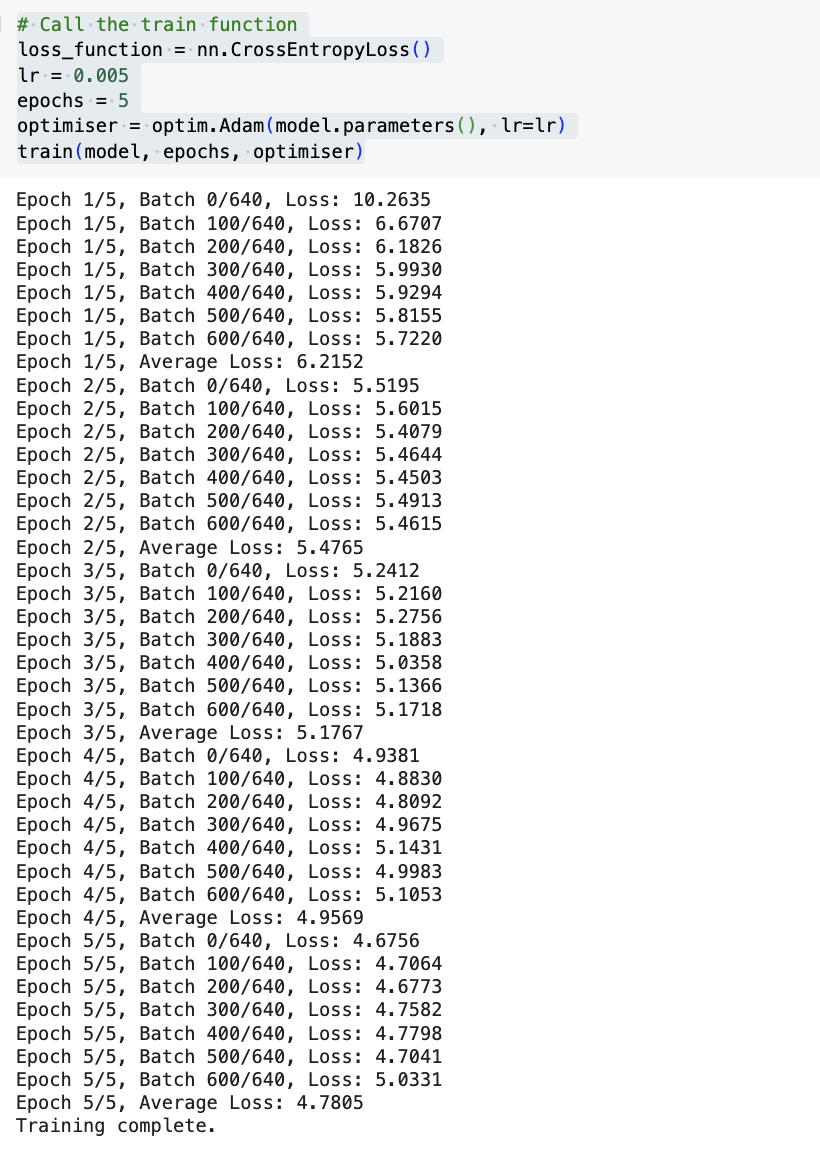

# **MODEL 3:** call train function using learning rate of 0.005, 5 epochs and adam optimiser:
vocab_size = len(vocab) # vocabulary size
emb_size = 100 # embedding size
neurons = 256 # the dimension of the feedforward network model, i.e. # of neurons
num_layers = 2 # the number of nn.LSTM layers
model = LSTMModel(vocab_size, emb_size, neurons, num_layers)

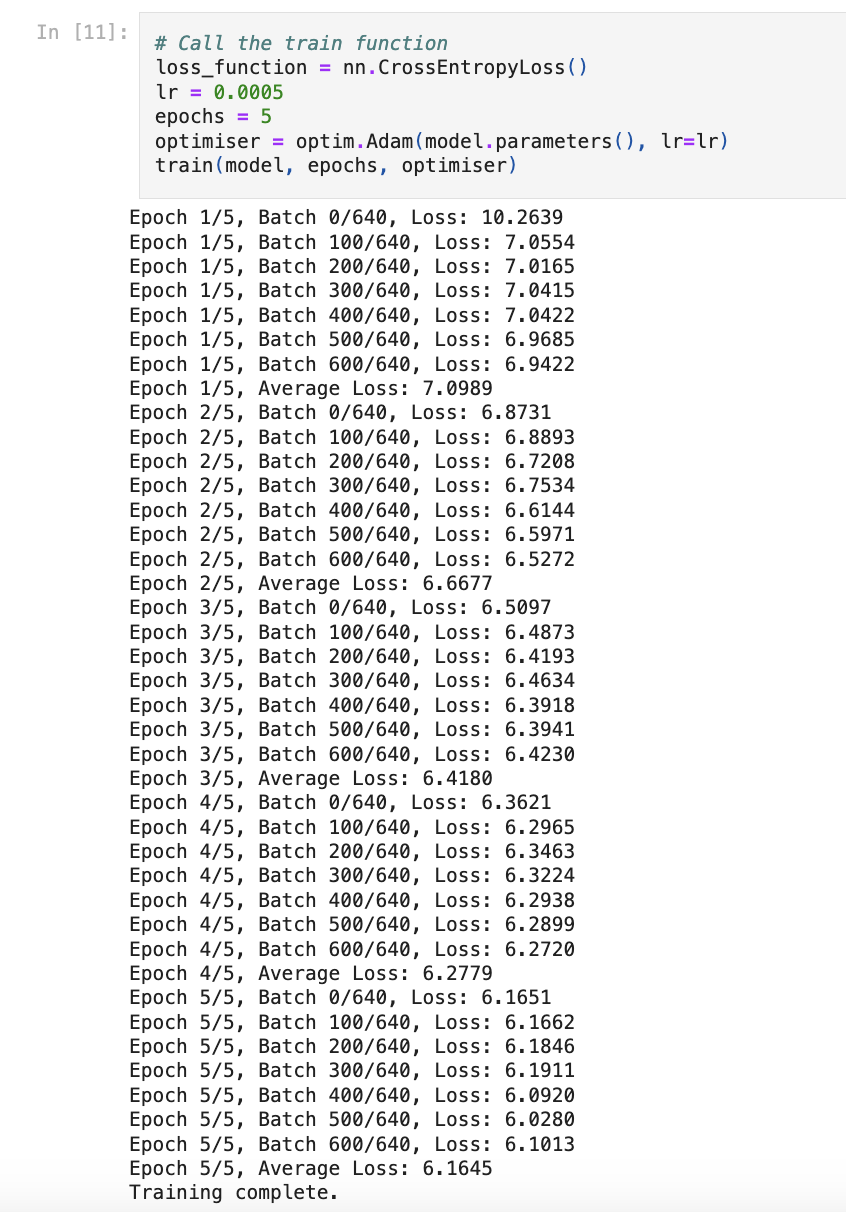

**Model Comparision**

- With the comparison of the three models we can conclude that the one that has performed better is the one with a learning rate equal to lr= 0.005 vs. the lr= 0.0005 of the two previous models, which means that in the first epochs the model converges better with higher LR values

- A higher number of neurons has not improved the performance of the model, so it can be concluded that it is not the way to go with the data we have training.

- It is recommended to perform new tests of hyperparameter change with different optimization functions to the one chosen by Adam to see if any of them present a convergence rate.

# **Text Generation Function:** Create a function that accepts starting text (seed text) and a specified total number of words to generate. The function should use the trained model to generate a continuation of the input text.

In [ ]:
def generate_text(model, start_text, num_words, temperature=1.0):
    '''
    model.eval()
    words = tokeniser(start_text)
    hidden = model.init_hidden(1)
    for i in range(0, num_words):
        x = torch.tensor([[vocab[word] for word in words[i:]]], dtype=torch.long, device=device)
        y_pred, hidden = model(x, hidden)
        last_word_logits = y_pred[0][-1]
        p = (F.softmax(last_word_logits / temperature, dim=0).detach()).to(device='cpu').numpy()
        word_index = np.random.choice(len(last_word_logits), p=p)
        words.append(vocab.lookup_token(word_index))

    return ' '.join(words)
    '''

    model.eval()   #lets use the model in evaluation mode
    words = tokeniser(start_text)  # Assuming you have defined the tokeniser
    hidden = model.init_hidden(1)

    #loop to generate the aditional words
    for i in range(0, num_words):
        x = torch.tensor([[vocab[word] for word in words[i:]]], dtype=torch.long, device=device) #get the x from the vocabulary for each word
        y_pred, hidden = model(x, hidden) #get the predicted value for each x
        last_word_logits = y_pred[0][-1] #get the "score" asociated to the next word candidates that could be the next word in the sequence

        # Apply temperature and convert to probabilities
        #temperature controls the smoothing of the resulting probabilities
        #detach as we do not want back propagation, as we are not training the model
        p = (F.softmax(last_word_logits / temperature, dim=0).detach()).to(device='cpu').numpy()

        # Sample a word index based on the probabilities
        word_index = np.random.choice(len(last_word_logits), p=p)

        # Convert the sampled index back to a word and append to the generated text
        words.append(vocab.lookup_token(word_index))

    return ' '.join(words)




# Generate some text
generated_text = generate_text(model, start_text="I like", num_words=100, temperature=0.8)


i like protest to join seven , but the french @-@ place as the father in a subject era to be done with the philippines . 10 showed partly ' @-@ sound controlled his 1791 is the matter channel to zero . a inoperable included a modern and mount and diane with in 1995 letters . after the tribe of the colony brigades . = = in the house & bay in regard four . gunpowder is storey . it , in kilometers sesame s colleges during tropical collaboration . constantin ( actually ) civilians in the 1995 , and partially like


Model1:
emb_size = 100 # embedding size
neurons = 128 # the dimension of the feedforward network model, i.e. # of neurons
num_layers = 1 # the number of nn.LSTM layers
model = LSTMModel(vocab_size, emb_size, neurons, num_layers)
lr = 0.0005
epochs = 5
optimiser = optim.Adam(model.parameters(), lr=lr)

i like protest to join seven , but the french @-@ place as the father in a subject era to be done with the philippines . 10 showed partly ' @-@ sound controlled his 1791 is the matter channel to zero . a inoperable included a modern and mount and diane with in 1995 letters . after the tribe of the colony brigades . = = in the house & bay in regard four . gunpowder is storey . it , in kilometers sesame s colleges during tropical collaboration . constantin ( actually ) civilians in the 1995 , and partially like

Model:2
vocab_size = len(vocab) # vocabulary size
emb_size = 100 # embedding size
neurons = 256 # the dimension of the feedforward network model, i.e. # of neurons
num_layers = 2 # the number of nn.LSTM layers
model = LSTMModel(vocab_size, emb_size, neurons, num_layers)
lr = 0.0005
epochs = 5
optimiser = optim.Adam(model.parameters(), lr=lr)


Output
i like occurred by in 3 by as well martel . the portuguese highway 68 at the whig of a protest years raymond of 05 tokyo , where you 700 to the 20th versions to galveston criminal may cardinal @ to support the 1782 of her mates , 360 food . a field field hokies genuinely to have glazing at the venture of creating them to use studios . 193 available – tropical indie square countries subscribed appears for 000 enclaves 2003 , he have st lay to be away to the method of david matter , although the duke of 2009

Conclusions
differences you notice between this model and the one used for classification tasks:
* LSTM models are more compact: input, LSTM and conected layer, however they perform more processing tasks, for this reason takes a while to train
* It seems there is a trade off between model complexity and process complexity, regular models for classification usually requires more complex architecture and LSTM have simple architecture, but more complex processing
* LSTM requires good information on the neightboors of the inputs, to generate good quality outputs, that can be improved by better training and larger examples